# Deep Learning and Neural Network - Question 2
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Data Proprocessing ](#1)
- [ 2 - Implementation ](#2)
- [ 3 - Result Analysis ](#3)

---

<a name="0"></a>
## 0 - Packages

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [albumentations](https://albumentations.ai) is a computer vision tool that boosts the performance of deep convolutional neural networks.

In [1]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Add, Lambda
from tensorflow.keras.models import Model

np.random.seed(42)

---

<a name="1"></a>
## 1 - Dataset Preparation

### ◆ Dataset Choosing

#### load random images with captions

In [2]:
def load_flickr8k_and_show_random_images(image_folder, captions_file, num_images):
    captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split("#")
            image_file = parts[0].strip()
            caption = parts[1].split('\t')[1].strip()
            if image_file not in captions:
                captions[image_file] = []
            captions[image_file].append(caption)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("\n".join(captions.get(image_file, ["No caption"])), fontsize=8)
    plt.tight_layout()
    plt.show()

In [12]:
def load_flickr8k_and_show_random_images_colab(image_folder, captions_file, num_images):
    captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            if line.startswith("image"):
                continue
            parts = line.strip().split(".jpg,")
            image_file = parts[0].strip()
            image_file=f'{image_file}.jpg'
            # print(line)
            caption = parts[1].strip()
            if image_file not in captions:
                captions[image_file] = []
            captions[image_file].append(caption)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(25, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("\n".join(captions.get(image_file, ["No caption"])), fontsize=8)
    plt.tight_layout()
    plt.show()

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flickr8k.zip
replace flickr8k/Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


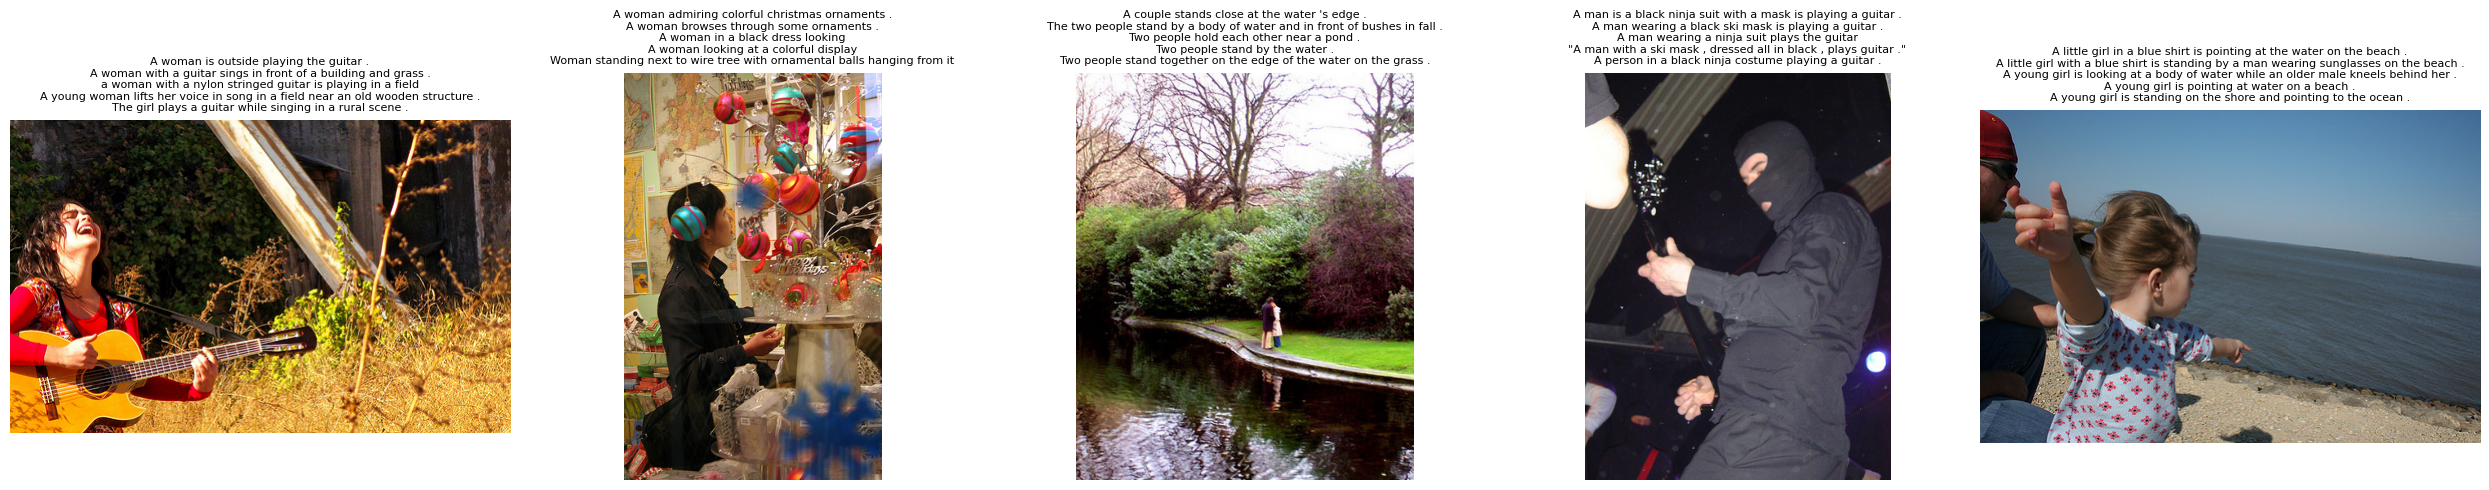

In [13]:
image_folder = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/"
caption_file = "/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt"

try:
  load_flickr8k_and_show_random_images(image_folder, caption_file, num_images=5)
except:
  #in colab
  !kaggle datasets download -d adityajn105/flickr8k
  !unzip flickr8k.zip -d flickr8k/
  image_folder = "/content/flickr8k/Images/"
  caption_file = "/content/flickr8k/captions.txt"
  load_flickr8k_and_show_random_images_colab(image_folder, caption_file, num_images=5)

---

### ◆ Images Preprocessing

#### resize images

In [5]:
def preprocess_images(image_folder, target_size=(224, 224)):
    resized_images = {}
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_folder, image_file)
            with Image.open(image_path) as img:
                img_resized = img.resize(target_size)
                img_array = np.array(img_resized)
                resized_images[image_file] = img_array
    return resized_images

In [6]:
images_dict = preprocess_images(image_folder)

#### rescale images

**since EfficientNetB0 uses pictures in range 0-255, we don't change pictures.**

---

### ◆ Captions Preprocessing

In [7]:
def preprocess_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            if image_folder.startswith('/content'):
                if line.startswith("image"):
                    continue
                parts = line.strip().split(".jpg,")
                image_file = parts[0].strip()
                image_file=f'{image_file}.jpg'
                # print(line)
                caption = parts[1].strip()
                caption_cleaned = re.sub(r"[^a-z\s]", "", caption)
                if image_file not in captions_dict:
                    captions_dict[image_file] = []
                captions_dict[image_file].append(caption_cleaned)
            else:
                parts = line.strip().split("#")
                image_file = parts[0].strip()
                if image_file.endswith('.jpg'):
                    caption = parts[1].split('\t')[1].strip().lower()
                    caption_cleaned = re.sub(r"[^a-z\s]", "", caption)
                    if image_file not in captions_dict:
                        captions_dict[image_file] = []
                    captions_dict[image_file].append(caption_cleaned)
    return captions_dict

In [8]:
captions_dict = preprocess_captions(caption_file)

#### tokenization

In [14]:
def tokenize_and_map_with_special_tokens(captions_dict, output_file="word_to_id.json"):
    all_words = []
    for captions in captions_dict.values():
        for caption in captions:
            all_words.extend(caption.split())
    word_counter = Counter(all_words)
    special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
    word_to_id = {token: idx for idx, token in enumerate(special_tokens)}
    word_to_id.update({word: idx + len(special_tokens) for idx, (word, _) in enumerate(word_counter.items())})
    tokenized_captions = {}
    for image, captions in captions_dict.items():
        tokenized_captions[image] = [
            [word_to_id["<sos>"]] +
            [word_to_id.get(word, word_to_id["<unk>"]) for word in caption.split()] +
            [word_to_id["<eos>"]]
            for caption in captions
        ]
    with open(output_file, "w") as json_file:
        json.dump(word_to_id, json_file, indent=4)
    return word_to_id, tokenized_captions

In [10]:
word_to_id, tokenized_captions = tokenize_and_map_with_special_tokens(captions_dict, "word_to_id.json")

In [15]:
def tokenize_and_pad_captions(captions_dict, word_to_id, caption_len):
    padded_captions = {}
    pad_id = word_to_id["<pad>"]
    sos_id = word_to_id["<sos>"]
    eos_id = word_to_id["<eos>"]
    unk_id = word_to_id["<unk>"]
    for image, captions in captions_dict.items():
        tokenized_padded_captions = []
        for caption in captions:
            tokenized_caption = [word_to_id.get(word, unk_id) for word in caption.split()]
            tokenized_caption = [sos_id] + tokenized_caption + [eos_id]
            if len(tokenized_caption) < caption_len:
                tokenized_caption += [pad_id] * (caption_len - len(tokenized_caption))
            else:
                tokenized_caption = tokenized_caption[:caption_len]
            tokenized_padded_captions.append(tokenized_caption)
        padded_captions[image] = tokenized_padded_captions
    return padded_captions

In [16]:
caption_len = 40
tokens_dict = tokenize_and_pad_captions(captions_dict, word_to_id, caption_len)

---

### ◆ Data Splitting

In [17]:
def sort_and_split_data(picture_dict, captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    sorted_keys = sorted(picture_dict.keys())
    sorted_pictures = [picture_dict[key] for key in sorted_keys]
    sorted_captions = [captions_dict[key] for key in sorted_keys]
    total_count = len(sorted_keys)
    train_count = int(train_ratio * total_count)
    val_count = int(val_ratio * total_count)
    test_count = total_count - (train_count + val_count)
    indices = np.random.permutation(total_count)
    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]
    train_pictures = [sorted_pictures[i] for i in train_indices]
    train_captions = [sorted_captions[i] for i in train_indices]
    val_pictures = [sorted_pictures[i] for i in val_indices]
    val_captions = [sorted_captions[i] for i in val_indices]
    test_pictures = [sorted_pictures[i] for i in test_indices]
    test_captions = [sorted_captions[i] for i in test_indices]
    return train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions

In [18]:
train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions = sort_and_split_data(images_dict, tokens_dict)

---

### ◆ Displaying Processed Data

#### id to caption

In [19]:
def ids_to_caption(id_list, id_to_word):
    words = []
    for i in id_list:
        word = id_to_word.get(i, "<unk>")
        if word == "<sos>":
            continue
        if word == "<eos>":
            break
        words.append(word)
    return " ".join(words)

#### random plot

In [20]:
def plot_images_with_captions(train_pictures, train_captions, id_to_word, num_images=5):
    selected_indices = np.random.choice(len(train_pictures), num_images, replace=False)
    plt.figure(figsize=(5, 25))
    for i, idx in enumerate(selected_indices):
        image = train_pictures[idx]
        caption = train_captions[idx][0]
        caption = ids_to_caption(caption, id_to_word)[1:]
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(caption, fontsize=12)
    plt.tight_layout()
    plt.show()

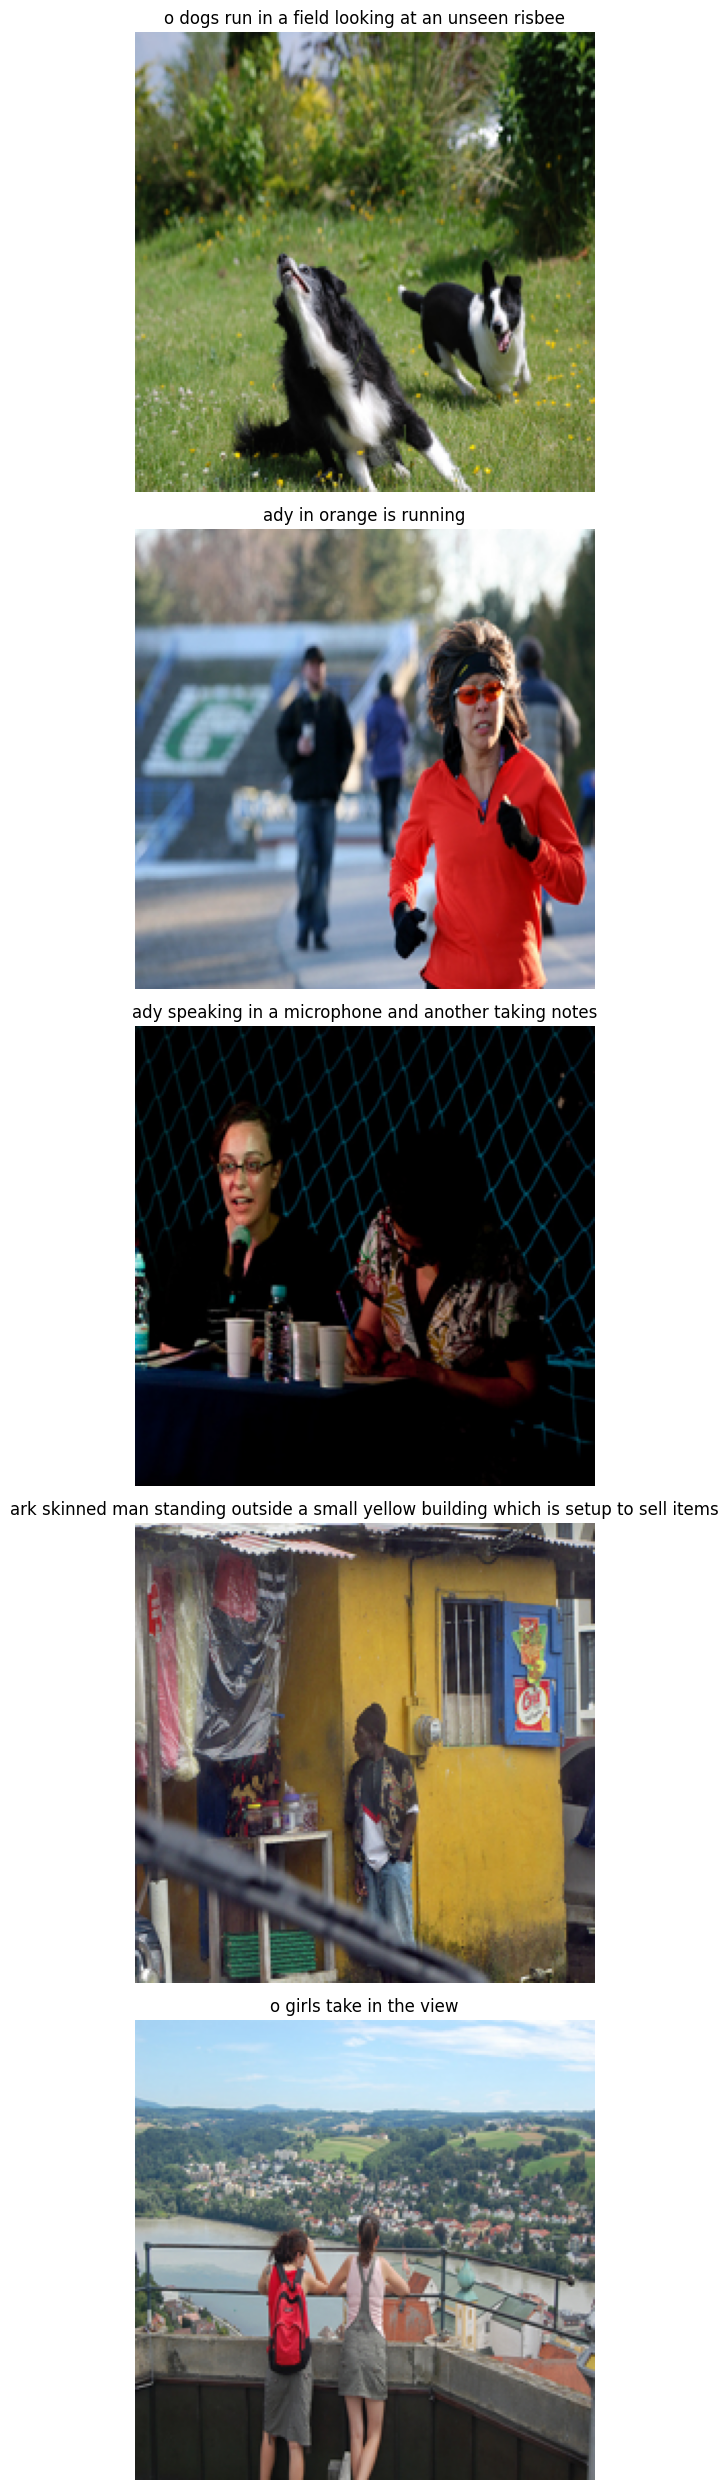

In [21]:
id_to_word = {v: k for k, v in word_to_id.items()}
plot_images_with_captions(train_pictures, train_captions, id_to_word)

#### scatter plot of caption lengths

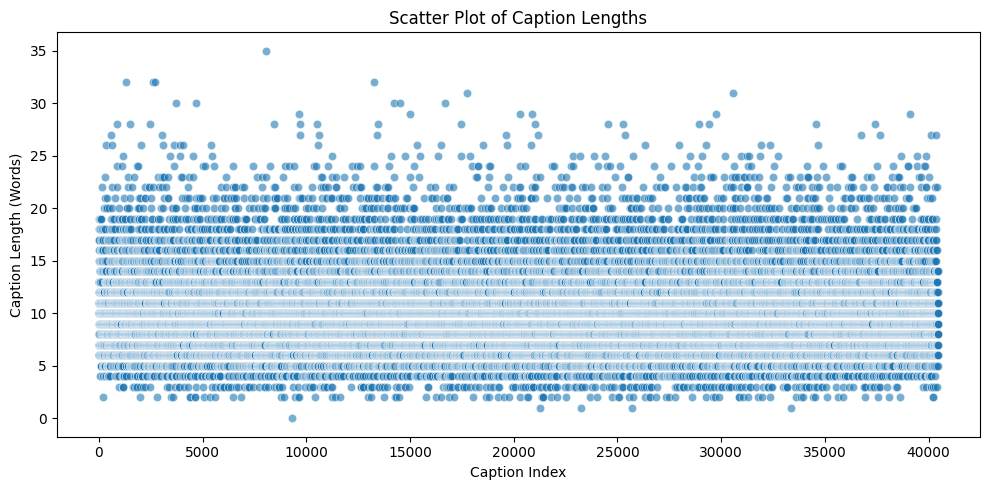

In [22]:
caption_lengths = []
for captions in captions_dict.values():
    for caption in captions:
        caption_lengths.append(len(caption.split()))  # Count words in caption
indices = range(len(caption_lengths))
plt.figure(figsize=(10, 5))
sns.scatterplot(x=indices, y=caption_lengths, alpha=0.6)
plt.xlabel("Caption Index")
plt.ylabel("Caption Length (Words)")
plt.title("Scatter Plot of Caption Lengths")
plt.tight_layout()
plt.show()

#### histogram of 20 most frequent words

<ipython-input-23-78bcf759ff0f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


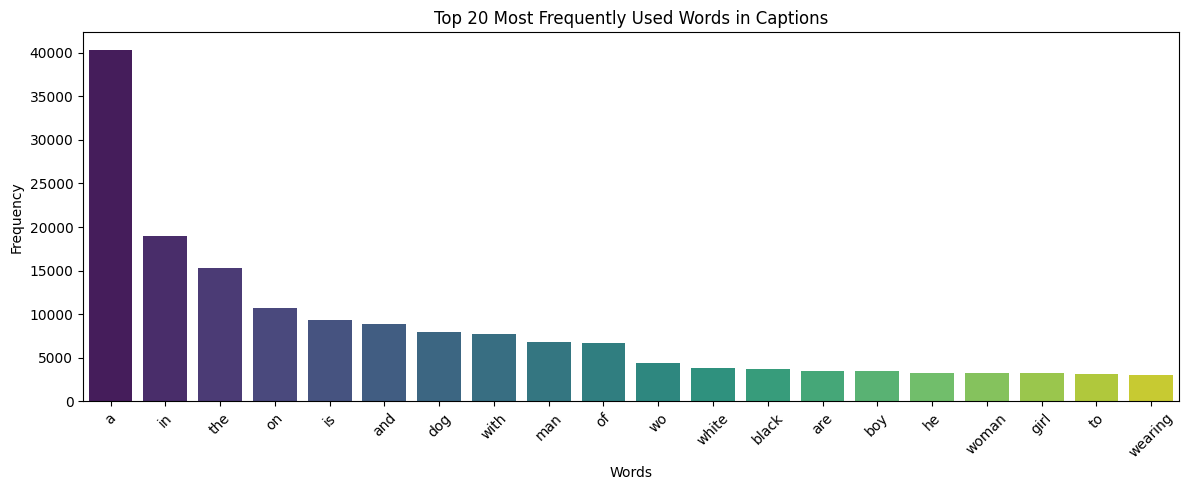

In [23]:
word_counter = Counter()
for captions in captions_dict.values():
    for caption in captions:
        words = caption.split()
        word_counter.update(words)
most_common_words = word_counter.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {20} Most Frequently Used Words in Captions")
plt.tight_layout()
plt.show()

### loaders

---

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FlickrDataset(Dataset):
    def __init__(self, image_paths, captions, transform=None):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.fromarray(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = torch.tensor(self.captions[idx][0])

        return image, caption

train_dataset = FlickrDataset(train_pictures, train_captions)
val_dataset = FlickrDataset(val_pictures, val_captions)
test_dataset = FlickrDataset(test_pictures, test_captions)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<a name="2"></a>
## 1 - CNN RNN Implementation

def cnn_rnn_model(vocab_size, embedding_dim, lstm_units, max_caption_len):
    # --- Encoder (CNN: EfficientNetB0) ---
    cnn_base = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")
    cnn_base.trainable = False
    image_input = Input(shape=(224, 224, 3), name="image_input")
    encoded_image = cnn_base(image_input)
    image_features = Dense(lstm_units, activation="relu", name="image_features")(encoded_image)
    # --- Decoder (RNN: LSTMs) ---
    caption_input = Input(shape=(max_caption_len,), name="caption_input")
    embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name="embedding")(caption_input)
    # Combine image features with LSTM inputs
    combined_input = Add(name="add_features")([tf.expand_dims(image_features, 1), embeddings])
    lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_1")(combined_input)
    lstm_output = LSTM(lstm_units, return_sequences=False, name="lstm_2")(lstm_output)
    # Output layer
    output = Dense(vocab_size, activation="softmax", name="output")(lstm_output)
    # --- Model ---
    model = Model(inputs=[image_input, caption_input], outputs=output, name="cnn_rnn_model")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

vocab_size = 5000          # Example vocabulary size
embedding_dim = 256        # Word embedding size
lstm_units = 32           # Number of LSTM units
model = cnn_rnn_model(vocab_size, embedding_dim, lstm_units, caption_len)
model.summary()

---

In [34]:
import torchvision.models as models
import torch

CNN = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
CNN.classifier = torch.nn.Identity()

inputs = torch.ones(1, 3, 224, 224)
outputs = CNN(inputs)

print(outputs.shape)

torch.Size([1, 1280])


In [35]:
for param in CNN.parameters():
    param.requires_grad = False

In [36]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-2])
        inputs = torch.cat((features, embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)

        return outputs

In [37]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = CNN
        self.fc = nn.Linear(1280, embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)
        # print(outputs.shape, embed_size)

    def forward(self, images, captions):
        with torch.no_grad():
            features = self.encoder(images)
            # print(features.shape)
        features = self.fc(features)
        features = features.unsqueeze(1)

        outputs = self.decoder.forward(features, captions)
        # print(outputs.shape)
        return outputs

In [ ]:
captions[:, :-2].shape

torch.Size([32, 38])

In [38]:
import torch.optim as optim
import torch.nn as nn
import torch.nn as nn

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_size = 256
hidden_size = 512
vocab_size = len(word_to_id)
num_epochs = 10
learning_rate = 5e-4

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, captions in train_loader:
        images=images.to(device)
        captions=captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        # print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            outputs = model(images, captions)
            outputs = outputs.reshape(-1, vocab_size)
            targets = captions[:, 1:].reshape(-1)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f}')

Epoch [1/10], Train Loss: 5.4734,Val Loss: 4.9255
Epoch [2/10], Train Loss: 4.7055,Val Loss: 4.7121
Epoch [3/10], Train Loss: 4.4653,Val Loss: 4.5852
Epoch [4/10], Train Loss: 4.2815,Val Loss: 4.5042
Epoch [5/10], Train Loss: 4.1251,Val Loss: 4.4631
Epoch [6/10], Train Loss: 3.9817,Val Loss: 4.4258
Epoch [7/10], Train Loss: 3.8472,Val Loss: 4.4041
Epoch [8/10], Train Loss: 3.7084,Val Loss: 4.3793
Epoch [9/10], Train Loss: 3.5656,Val Loss: 4.3769
Epoch [10/10], Train Loss: 3.4325,Val Loss: 4.3703


In [39]:
test_loss = 0
with torch.no_grad():
    for images, captions in test_loader:
        images = images.to(device)
        captions = captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 4.4530


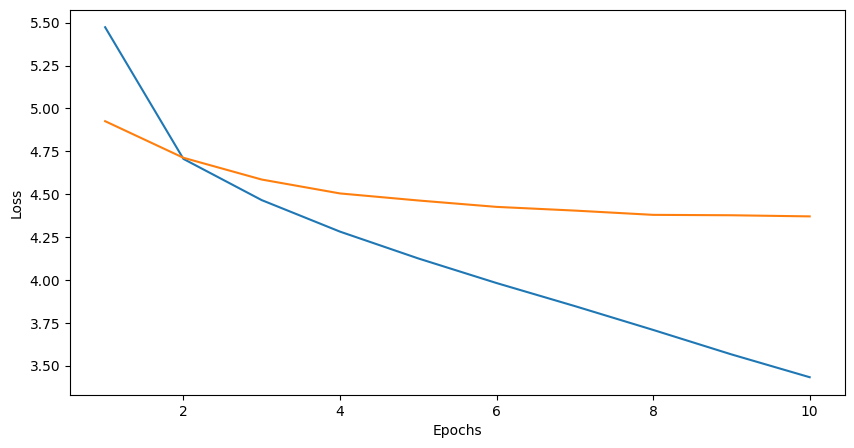

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [41]:
def generate_caption(model, image, word_to_id, max_length=30):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image.unsqueeze(0).to(device))
        feature = model.fc(feature).unsqueeze(1)

        inputs = feature
        states = None
        generated_indices = []

        for _ in range(max_length):
            hiddens, states = model.decoder.lstm(inputs, states)
            outputs = model.decoder.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            generated_indices.append(predicted.item())
            if predicted.item() == word_to_id['<eos>']:
                break
            inputs = model.decoder.embedding(predicted).unsqueeze(1)

    generated_caption = [id_to_word.get(idx, '<unk>') for idx in generated_indices]
    return ' '.join(generated_caption)

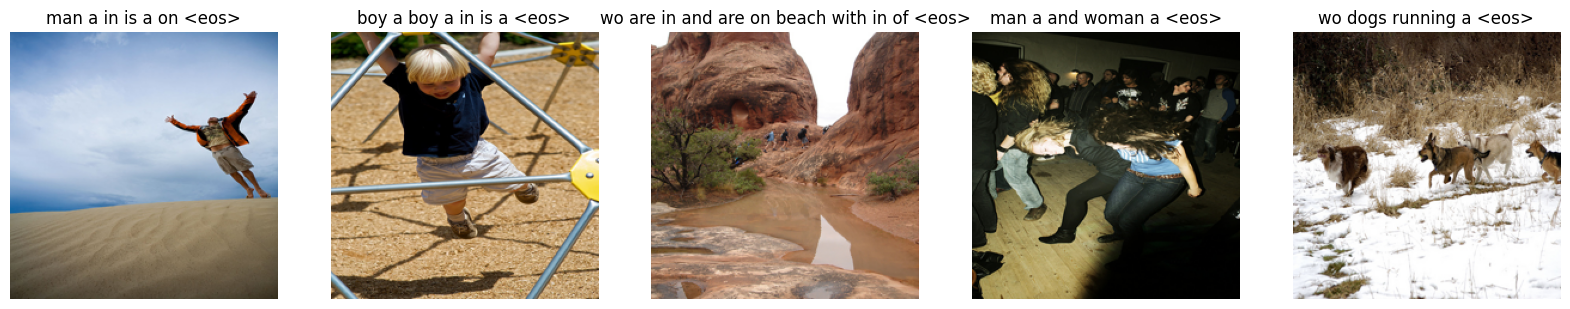

In [42]:
random_idx = random.sample(range(len(test_dataset)), 5)
images = [test_dataset[i][0] for i in random_idx]

captions = []
for image in images:
    image = image.to(device)
    caption = generate_caption(model, image, word_to_id)
    captions.append(caption)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, (image, caption) in enumerate(zip(images, captions)):
    axs[i].imshow(image.cpu().permute(1,2,0).numpy())
    axs[i].set_title(caption)
    axs[i].axis('off')

plt.show()

## 2-CNN-Attention

In [52]:
CNN.avgpool=torch.nn.Identity()

In [53]:
inputs = torch.ones(1, 3, 224, 224).to(device)
outputs = CNN(inputs)

print(outputs.shape)

torch.Size([1, 62720])


In [48]:
class Attention(nn.Module):
    def __init__(self, encoder_dim):
        super(Attention, self).__init__()
        self.query = nn.Linear(512, 512)
        self.key = nn.Linear(encoder_dim, 512)
        self.value = nn.Linear(512, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, img_features, hidden_state):
        query = self.query(hidden_state).unsqueeze(1)
        key = self.key(img_features)
        e = self.value(self.tanh(key + query)).squeeze(2)
        a = self.softmax(e)

        out = (img_features * a.unsqueeze(2)).sum(1)

        return out, a

In [49]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, vocab_size, encoder_dim):
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.init_h = nn.Linear(encoder_dim, 512)
        self.init_c = nn.Linear(encoder_dim, 512)
        self.activation = nn.Tanh()
        self.beta_layer = nn.Linear(512, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.linear = nn.Linear(512, vocab_size)
        self.dropout = nn.Dropout()

        self.attention = Attention(encoder_dim)
        self.embedding_layer = nn.Embedding(vocab_size, 512)
        self.lstm_cell = nn.LSTMCell(encoder_dim + 512, 512)

    def forward(self, features, captions):
        batch_size = features.size(0)
        h, c = self.init_lstm(features)

        max_seq_len = max(len(cap) for cap in captions) - 1
        predictions = torch.zeros(batch_size, max_seq_len, self.vocab_size).cuda()

        prev_tokens = torch.zeros(batch_size, 1).long().cuda()
        embeddings = self.embedding_layer(prev_tokens)

        for t in range(max_seq_len):
            context, alpha = self.attention(features, h)
            gating = self.sigmoid(self.beta_layer(h))
            gated_context = gating * context

            embeddings = embeddings.squeeze(1) if embeddings.dim() == 3 else embeddings
            lstm_input = torch.cat((embeddings, gated_context), dim=1)

            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.linear(self.dropout(h))

            predictions[:, t] = output

            if not self.training:
                predicted_tokens = output.max(1)[1].unsqueeze(1)
                embeddings = self.embedding_layer(predicted_tokens)

        return predictions

    def init_lstm(self, features):
        mean_features = features.mean(dim=1)
        h = self.activation(self.init_h(mean_features))
        c = self.activation(self.init_c(mean_features))
        return h, c


In [54]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = CNN
        self.fc = nn.Linear(1280 * 7 * 7, embed_size)
        self.decoder = Decoder(vocab_size, embed_size)

    def forward(self, images, captions):
        with torch.no_grad():
            features = self.encoder(images)
        features = features.reshape(features.size(0), -1)
        features = self.fc(features)
        features = features.unsqueeze(1)

        outputs = self.decoder.forward(features, captions)
        return outputs

In [55]:
import torch.optim as optim
import torch.nn as nn

embed_size = 256
hidden_size = 512
vocab_size = len(word_to_id)
num_epochs = 10
learning_rate = 1e-4

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss=0
    for images, captions in train_loader:
        images=images.to(device)
        captions=captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        # print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            outputs = model(images, captions)
            outputs = outputs.reshape(-1, vocab_size)
            targets = captions[:, 1:].reshape(-1)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f}')

Epoch [1/10], Train Loss: 6.0612,Val Loss: 5.3725
Epoch [2/10], Train Loss: 5.3185,Val Loss: 5.3205
Epoch [3/10], Train Loss: 5.1512,Val Loss: 5.2695
Epoch [4/10], Train Loss: 5.0054,Val Loss: 5.2314
Epoch [5/10], Train Loss: 4.8594,Val Loss: 5.2064
Epoch [6/10], Train Loss: 4.7306,Val Loss: 5.1704
Epoch [7/10], Train Loss: 4.6070,Val Loss: 5.1575
Epoch [8/10], Train Loss: 4.4899,Val Loss: 5.1620
Epoch [9/10], Train Loss: 4.3874,Val Loss: 5.1416
Epoch [10/10], Train Loss: 4.2774,Val Loss: 5.1372


In [57]:
test_loss = 0
with torch.no_grad():
    for images, captions in test_loader:
        images = images.to(device)
        captions = captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 5.1628


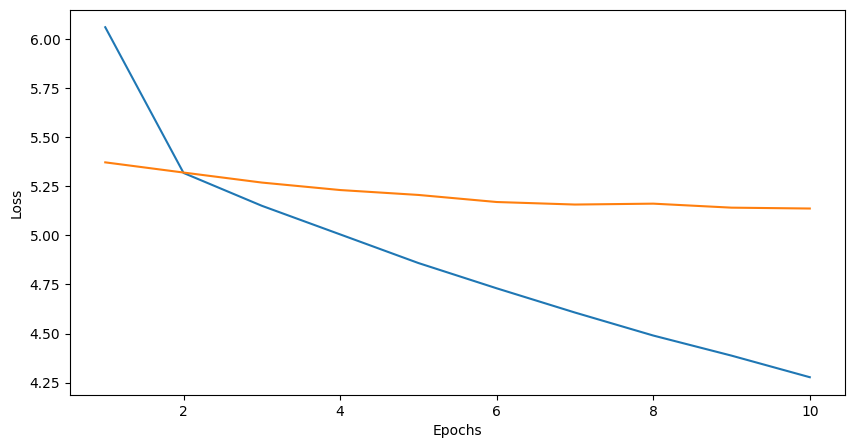

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [77]:
def generate_caption(model, image, word_to_id, id_to_word, max_length=30):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        features = features.reshape(features.size(0), -1)
        features = model.fc(features)
        features = features.unsqueeze(1)

        h, c = model.decoder.init_lstm(features)

        inputs = model.decoder.embedding_layer(torch.tensor([[word_to_id['<sos>']]]).to(device))

        generated_indices = []
        already_generated = set()

        for _ in range(max_length):
            context, alpha = model.decoder.attention(features, h)
            gate = model.decoder.sigmoid(model.decoder.beta_layer(h))
            gated_context = gate * context
            gated_context = gated_context.unsqueeze(0) if gated_context.dim() == 1 else gated_context
            lstm_input = torch.cat((inputs.squeeze(1), gated_context), dim=1)
            lstm_input = lstm_input.unsqueeze(1)
            h, c = model.decoder.lstm_cell(lstm_input.squeeze(1), (h, c))
            output = model.decoder.linear(model.decoder.dropout(h))
            predicted = output.argmax(1).item()

            while predicted in already_generated:
                output[0, predicted] = -float('inf')
                predicted = output.argmax(1).item()

            generated_indices.append(predicted)
            already_generated.add(predicted)

            if predicted == word_to_id['<eos>']:
                break

            inputs = model.decoder.embedding_layer(torch.tensor([[predicted]]).to(device))

    generated_caption = [id_to_word.get(idx, '<unk>') for idx in generated_indices]
    return ' '.join(generated_caption)


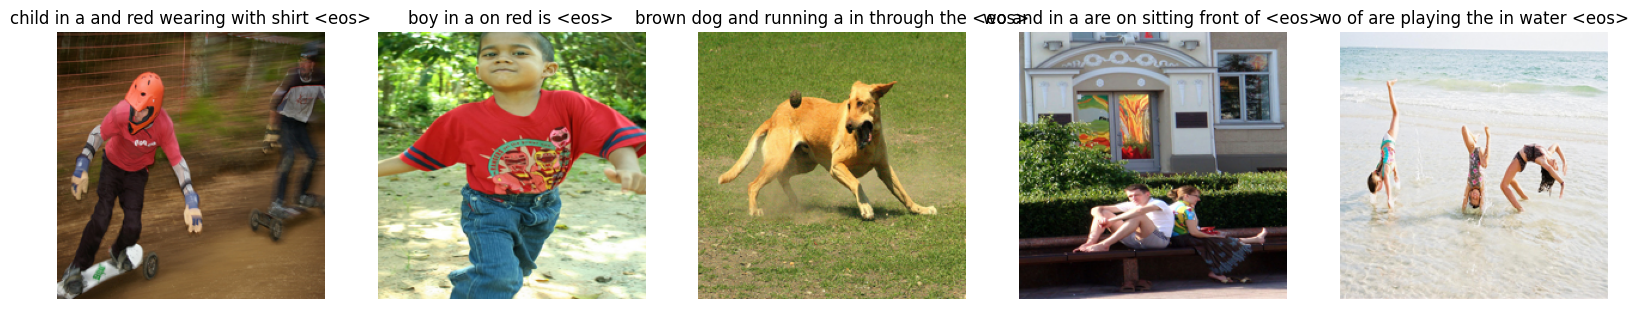

In [79]:
random_idx = random.sample(range(len(test_dataset)), 5)
images = [test_dataset[i][0] for i in random_idx]

captions = []
for image in images:
    image = image.to(device)
    caption = generate_caption(model, image, word_to_id, id_to_word)
    captions.append(caption)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, (image, caption) in enumerate(zip(images, captions)):
    axs[i].imshow(image.cpu().permute(1,2,0).numpy())
    axs[i].set_title(caption)
    axs[i].axis('off')

plt.show()

## 3-CNN-Transformer

In [114]:
import torchvision.models as models
import torch

CNN = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
CNN.classifier = torch.nn.Identity()
CNN.avgpool=torch.nn.Identity()

for param in CNN.parameters():
    param.requires_grad = False

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.scale = embed_size ** 0.5

    def forward(self, x, context=None):
        if context is None:
            context = x

        q = self.query(x)
        k = self.key(context)
        v = self.value(context)

        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        return torch.matmul(attn_weights, v)

class Transformer(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, sequence_length):
        super().__init__()
        self.encoder_attn = Attention(embed_size)
        self.encoder_ffn = nn.Sequential(
            nn.Linear(embed_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_size)
        )

        self.decoder_attn = Attention(embed_size)
        self.cross_attn = Attention(embed_size)
        self.decoder_ffn = nn.Sequential(
            nn.Linear(embed_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_size)
        )

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(sequence_length, embed_size)
        self.out = nn.Linear(embed_size, vocab_size)

    def forward(self, img_embed, captions):
        enc_x = self.encoder_attn(img_embed)
        enc_x = enc_x + self.encoder_ffn(enc_x)

        positions = torch.arange(captions.shape[1], device=captions.device).unsqueeze(0)
        positions = torch.clamp(positions, min=0, max=self.position_embedding.num_embeddings - 1)
        dec_x = self.embedding(torch.clamp(captions, min=0, max=self.embedding.num_embeddings - 1)) + self.position_embedding(positions)

        attn_mask = self.mask_tokens(dec_x.shape[1], dec_x.device)

        dec_x = self.decoder_attn(dec_x)
        dec_x = dec_x + self.cross_attn(dec_x, enc_x)
        dec_x = dec_x + self.decoder_ffn(dec_x)

        return self.out(dec_x)

    def mask_tokens(self, size, device):
        mask = torch.tril(torch.ones(size, size, device=device))
        return mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))


class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, seq_len):
        super().__init__()
        self.cnn_model = CNN
        self.transformer = Transformer(embed_size, hidden_size, vocab_size, seq_len)
        self.fc = nn.Linear(1280*7*7, embed_size)

    def forward(self, images, captions):
        img_embed = self.cnn_model(images).flatten(start_dim=1)
        img_embed = self.fc(img_embed).unsqueeze(0)
        return self.transformer(img_embed, captions)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256
hidden_size = 512
vocab_size = len(word_to_id)
num_epochs = 10
learning_rate = 1e-4

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size, 30)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'], label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss=0
    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, :].reshape(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions)
            outputs = outputs.reshape(-1, vocab_size)
            targets = captions[:, :].reshape(-1)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f}')


Epoch [1/10], Train Loss: 5.4621,Val Loss: 4.4829
Epoch [2/10], Train Loss: 4.1775,Val Loss: 3.8709
Epoch [3/10], Train Loss: 3.6503,Val Loss: 3.4833
Epoch [4/10], Train Loss: 3.2974,Val Loss: 3.1904
Epoch [5/10], Train Loss: 3.0424,Val Loss: 2.9989
Epoch [6/10], Train Loss: 2.8297,Val Loss: 2.7905
Epoch [7/10], Train Loss: 2.6399,Val Loss: 2.6448
Epoch [8/10], Train Loss: 2.4922,Val Loss: 2.5288
Epoch [9/10], Train Loss: 2.3707,Val Loss: 2.4323
Epoch [10/10], Train Loss: 2.2810,Val Loss: 2.3600


In [121]:
model.eval()
test_loss = 0
with torch.no_grad():
    for images, captions in test_loader:
        images, captions = images.to(device), captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, :].reshape(-1)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')


Test Loss: 2.4054


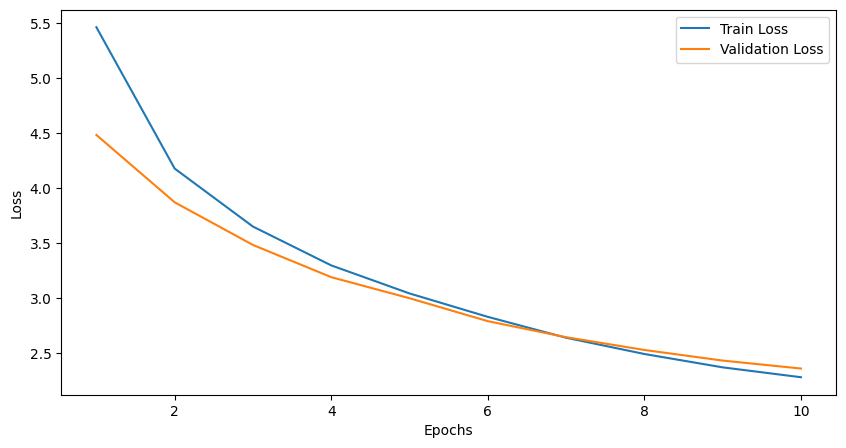

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [132]:
import torch
import torch.nn.functional as F

def generate_caption(model, image, word_to_id, id_to_word, max_length=30, beam_size=10):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        img_embed = model.cnn_model(image).flatten(start_dim=1)
        img_embed = model.fc(img_embed).unsqueeze(0)

        start_token = torch.tensor([[word_to_id['<sos>']]], device=device)
        beam = [(start_token, 0, [])]

        for _ in range(max_length):
            new_beam = []
            for seq, score, gen_idxs in beam:
                outputs = model.transformer(img_embed, seq)
                logits = outputs[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                topk_probs, topk_idxs = probs.topk(beam_size, dim=-1)

                for i in range(beam_size):
                    new_seq = torch.cat([seq, topk_idxs[:, i].unsqueeze(0)], dim=1)
                    new_score = score - torch.log(topk_probs[0, i])
                    new_gen_idxs = gen_idxs + [topk_idxs[0, i].item()]

                    if new_gen_idxs[-1] == word_to_id['<eos>']:
                        return ' '.join([id_to_word.get(idx, '<unk>') for idx in new_gen_idxs[:-1]])

                    if len(new_gen_idxs) > 1 and (new_gen_idxs[-1] in new_gen_idxs[:-1]):
                        continue

                    new_beam.append((new_seq, new_score, new_gen_idxs))

            beam = sorted(new_beam, key=lambda x: x[1])[:beam_size]

        best_seq, best_score, best_gen_idxs = beam[0]
        generated_caption = ' '.join([id_to_word.get(idx, '<unk>') for idx in best_gen_idxs])
        return generated_caption


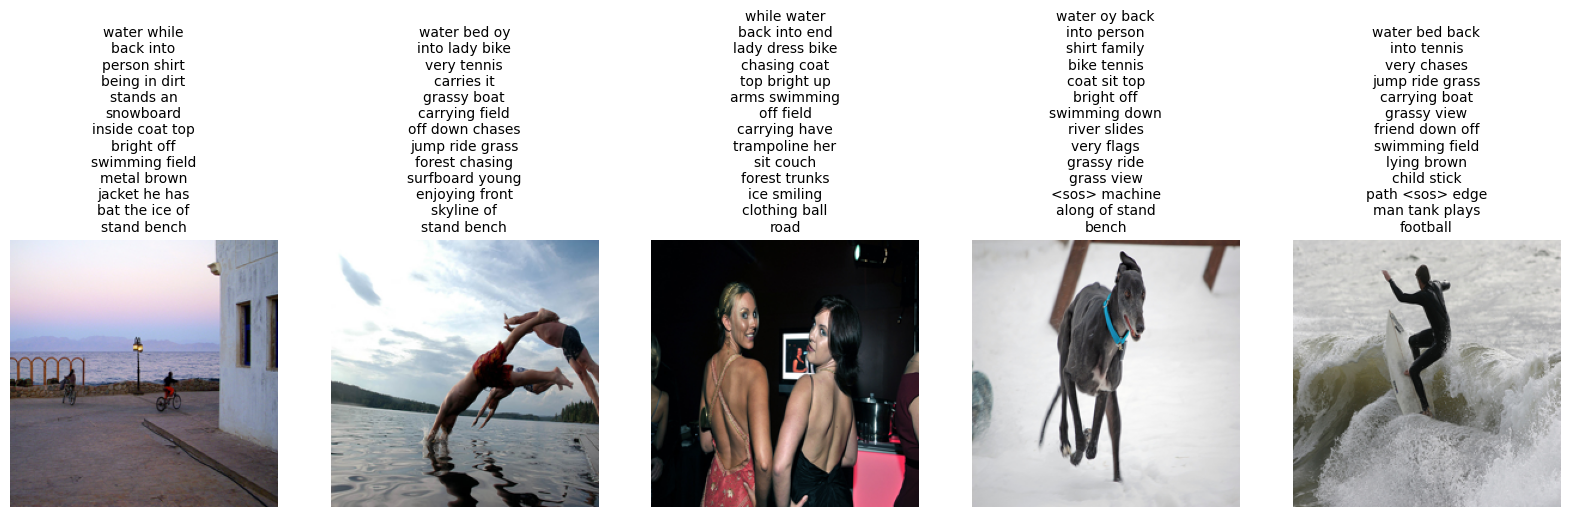

In [134]:
import random
import matplotlib.pyplot as plt
import textwrap

random_idx = random.sample(range(len(test_dataset)), 5)
images = [test_dataset[i][0] for i in random_idx]

captions = []
for image in images:
    image = image.to(device)
    caption = generate_caption(model, image, word_to_id, id_to_word)
    captions.append(caption)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, (image, caption) in enumerate(zip(images, captions)):
    axs[i].imshow(image.cpu().permute(1, 2, 0).numpy())
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=15))
    axs[i].set_title(wrapped_caption, fontsize=10)
    axs[i].axis('off')

plt.show()